In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
        classification_report, confusion_matrix, r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score, f1_score, roc_auc_score, roc_curve
)

from sklearn.inspection import PartialDependenceDisplay

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.model_selection import cross_val_score

In [4]:
from category_encoders import TargetEncoder 
from sklearn.feature_selection import SelectFromModel

In [5]:
TrainPre2019 = pd.read_csv('../data/Train_Pre2019_TimeIntervalLabeled_PerTruck.csv')

/var/folders/nl/hqcw9pqd0ns4q0b61syv0q2m0000gn/T/ipykernel_7098/1553715100.py:1: DtypeWarning: Columns (17,41,44) have mixed types. Specify dtype option on import or set low_memory=False.
  TrainPre2019 = pd.read_csv('../data/Train_Pre2019_TimeIntervalLabeled_PerTruck.csv')


In [6]:
TrainPre2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945558 entries, 0 to 945557
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0.1                    945558 non-null  int64  
 1   Unnamed: 0                      945558 non-null  int64  
 2   RecordID                        945558 non-null  int64  
 3   ESS_Id                          945558 non-null  int64  
 4   EventTimeStamp                  945558 non-null  object 
 5   eventDescription                898600 non-null  object 
 6   actionDescription               0 non-null       float64
 7   ecuSoftwareVersion              743930 non-null  object 
 8   ecuSerialNumber                 704649 non-null  object 
 9   ecuModel                        897109 non-null  object 
 10  ecuMake                         897109 non-null  object 
 11  ecuSource                       945558 non-null  int64  
 12  spn             

**Goal:** Predict the rank based on the total shots.

In [7]:
TrainPre2019['time_interval_to_SPN5246_class'].value_counts()

time_interval_to_SPN5246_class
0    943246
2      1546
1       766
Name: count, dtype: int64


class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = OneHotEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = OneHotEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [8]:
TrainPre2019[['ecuSource', 'LampStatus', 'time_interval_to_SPN5246_class']] = TrainPre2019[['ecuSource', 'LampStatus', 'time_interval_to_SPN5246_class']].astype('str')

In [9]:
NumericColumns = TrainPre2019.select_dtypes(include=[np.number]).columns.tolist()
NumericColumns_Without_MatchID = NumericColumns.pop(0)
NumericColumns

['Unnamed: 0',
 'RecordID',
 'ESS_Id',
 'actionDescription',
 'spn',
 'fmi',
 'activeTransitionCount',
 'faultValue',
 'MCTNumber',
 'Latitude',
 'Longitude',
 'FaultId',
 'AcceleratorPedal',
 'BarometricPressure',
 'CruiseControlSetSpeed',
 'DistanceLtd',
 'EngineCoolantTemperature',
 'EngineLoad',
 'EngineOilPressure',
 'EngineOilTemperature',
 'EngineRpm',
 'EngineTimeLtd',
 'FuelLevel',
 'FuelLtd',
 'FuelRate',
 'FuelTemperature',
 'IntakeManifoldTemperature',
 'ServiceDistance',
 'Speed',
 'Throttle',
 'TurboBoostPressure',
 'is_fullderate',
 'is_fullderate_group',
 'time_to_next_SPN5246']

Among numeric columns,

Will exclude: 

['Unnamed: 0',
 'RecordID',
 'ESS_Id',
 'actionDescription',
 'spn',
 'fmi',
 'activeTransitionCount',
 'faultValue',
 'MCTNumber',
 'Latitude',
 'Longitude',
 'FaultId',
 'is_fullderate',
 'is_fullderate_group',
 'time_to_next_SPN5246',
 'ServiceDistance']

Will keep:


['AcceleratorPedal',
 'BarometricPressure',
 'CruiseControlSetSpeed',
 'DistanceLtd',
 'EngineCoolantTemperature',
 'EngineLoad',
 'EngineOilPressure',
 'EngineOilTemperature',
 'EngineRpm',
 'EngineTimeLtd',
 'FuelLevel',
 'FuelLtd',
 'FuelRate',
 'FuelTemperature',
 'IntakeManifoldTemperature',
 'Speed',
 'Throttle',
 'TurboBoostPressure']

In [10]:
NonNumericColumns = TrainPre2019.select_dtypes(exclude=[np.number]).columns.tolist()
NonNumericColumns

['EventTimeStamp',
 'eventDescription',
 'ecuSoftwareVersion',
 'ecuSerialNumber',
 'ecuModel',
 'ecuMake',
 'ecuSource',
 'active',
 'EquipmentID',
 'LocationTimeStamp',
 'CruiseControlActive',
 'IgnStatus',
 'LampStatus',
 'ParkingBrake',
 'SwitchedBatteryVoltage',
 'spn_fmi',
 'EquipID_Index',
 'time_interval_to_SPN5246_class']

Among non-numeric columns,

Will exclude:

['EventTimeStamp',
 'eventDescription',
 'EquipmentID',
 'LocationTimeStamp',
 'EquipID_Index']

Will keep:

['ecuSoftwareVersion',
 'ecuSerialNumber',
 'ecuModel',
 'ecuMake',
 'ecuSource',
 'active',
 'CruiseControlActive',
 'IgnStatus',
 'LampStatus',
 'ParkingBrake',
 'SwitchedBatteryVoltage',
 'spn_fmi']

In [11]:
X = TrainPre2019.drop(columns = [   'Unnamed: 0',
                                    'RecordID',
                                    'ESS_Id',
                                    'actionDescription',
                                    'spn',
                                    'fmi',
                                    'activeTransitionCount',
                                    'faultValue',
                                    'MCTNumber',
                                    'Latitude',
                                    'Longitude',
                                    'FaultId',
                                    'is_fullderate',
                                    'is_fullderate_group',
                                    'time_to_next_SPN5246',
                                    'ServiceDistance',
                                    'EventTimeStamp',
                                    'eventDescription',
                                    'EquipmentID',
                                    'LocationTimeStamp',
                                    'EquipID_Index',
                                    'time_interval_to_SPN5246_class',                                                    
                                ]
                      )
y = TrainPre2019['time_interval_to_SPN5246_class']

In [12]:
X

,Unnamed: 0.1,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,active,AcceleratorPedal,BarometricPressure,CruiseControlActive,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_fmi
0,43695,unknown,unknown,unknown,unknown,11,True,14.4,13.9200,False,...,134.6,True,154.4,1279.0,False,4.475814,3276.75,14.4,0.58,639.0_2.0
1,45443,unknown,unknown,unknown,unknown,49,True,89.6,14.4275,False,...,100.4,True,120.2,4351.0,False,64.637170,3276.75,89.6,4.64,596.0_31.0
2,49998,PC4__1284P4C_2*,6U13D13,MX,PCAR,0,True,0.0,14.3550,False,...,120.2,True,118.4,17407.0,False,63.525490,3276.75,0.0,20.30,3226.0_10.0
3,54040,unknown,unknown,unknown,unknown,11,True,12.0,14.5725,False,...,109.4,True,107.6,1279.0,False,4.364162,3276.75,12.0,1.45,639.0_2.0
4,54132,unknown,unknown,unknown,unknown,11,False,NaN,NaN,NaN,...,NaN,NaN,NaN,1279.0,NaN,NaN,NaN,NaN,NaN,639.0_2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
945553,3991,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,CMMNS,0,False,NaN,NaN,NaN,...,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,1761.0_18.0
945554,5856,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,CMMNS,0,True,0.0,14.2100,False,...,32.0,True,84.2,17407.0,False,2.058292,3276.75,0.0,0.29,5848.0_9.0
945555,5864,05317106*04119044*051914190353*09400015*G1*BDR*,79751302,6X1u13D1500000000,CMMNS,0,False,NaN,NaN,NaN,...,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN,5848.0_9.0
945556,4423,unknown,unknown,unknown,unknown,11,True,21.6,14.4275,False,...,32.0,True,93.2,1279.0,False,4.378725,3276.75,0.0,1.74,639.0_2.0


In [13]:
y

0         0
1         0
2         0
3         0
4         0
         ..
945553    0
945554    0
945555    0
945556    0
945557    0
Name: time_interval_to_SPN5246_class, Length: 945558, dtype: object

In [14]:
X.describe()

,Unnamed: 0.1,AcceleratorPedal,BarometricPressure,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IntakeManifoldTemperature,Speed,Throttle,TurboBoostPressure
count,9.455580e+05,424358.000000,474521.000000,465383.000000,474430.000000,474488.000000,474031.000000,474597.000000,473100.000000,474818.000000,470684.000000,400576.000000,473878.000000,473795.000000,247372.000000,474592.000000,472999.000000,319235.000000,472518.000000
mean,4.728048e+05,28.541964,14.191881,62.181007,364649.003943,169.567350,31.972046,33.441511,187.292017,990.943887,7200.661015,61.692614,50561.567985,4.630860,37.023005,106.751831,26.339840,66.092073,6.289805
std,2.730089e+05,36.575343,1.194569,12.223644,142702.162418,32.833615,30.646621,11.281120,61.260341,402.053564,3617.559484,22.362167,24175.339372,5.787473,23.115581,25.486344,28.238055,46.339979,8.563973
min,0.000000e+00,0.000000,3.045000,0.000000,0.000000,-7.600000,0.000000,0.000000,-39.156250,0.000000,0.000000,0.000000,0.000000,0.000000,17.600000,-40.000000,0.000000,0.000000,0.000000
25%,2.363892e+05,0.000000,14.210000,64.622600,267356.325000,170.600000,11.000000,28.420000,179.993700,602.375000,4986.700000,45.600000,33491.996925,0.647223,32.000000,89.600000,0.000000,0.000000,0.580000
50%,4.727785e+05,3.600000,14.355000,66.486720,379834.450000,183.200000,19.000000,36.540000,202.775000,1099.625000,7381.900000,60.000000,51943.886413,1.690706,32.000000,109.400000,9.679798,100.000000,2.030000
75%,7.091678e+05,48.800000,14.500000,66.486720,481544.600000,186.800000,48.000000,39.440000,214.531300,1348.625000,9644.300000,78.000000,68751.172791,7.211920,32.000000,125.600000,60.018145,100.000000,8.700000
max,1.053228e+06,100.000000,15.225000,69.593570,649549.000000,406.400000,101.000000,145.000000,3212.544000,2694.125000,113033.700000,100.000000,312737.574126,25.611560,231.800000,264.200000,158.447200,100.000000,63.220000


In [15]:
X

le_y = LabelEncoder()

y_fitted = le_y.fit(y)
y_encoded = le_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.2, random_state = 321, shuffle=True, stratify = y_encoded)


In [16]:
# scaler = StandardScaler()


ct = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), [  'AcceleratorPedal',
                                        'BarometricPressure',
                                        'CruiseControlSetSpeed',
                                        'DistanceLtd',
                                        'EngineCoolantTemperature',
                                        'EngineLoad',
                                        'EngineOilPressure',
                                        'EngineOilTemperature',
                                        'EngineRpm',
                                        'EngineTimeLtd',
                                        'FuelLevel',
                                        'FuelLtd',
                                        'FuelRate',
                                        'FuelTemperature',
                                        'IntakeManifoldTemperature',
                                        'Speed',
                                        'Throttle',
                                        'TurboBoostPressure'
                                        ]),
        ('target_encoder', TargetEncoder(), [   'ecuSoftwareVersion',
                                                'ecuSerialNumber',
                                                'ecuModel',
                                                'ecuMake',
                                                'ecuSource',
                                                'active',
                                                'CruiseControlActive',
                                                'IgnStatus',
                                                'LampStatus',
                                                'ParkingBrake',
                                                'SwitchedBatteryVoltage',
                                                'spn_fmi'
                                            ])
    ],
    remainder='passthrough'
)

xgbc_pipe = Pipeline(
    steps=[
        ('preprocessor', ct),
        ('xgbc', XGBClassifier(
                    eval_metric='mlogloss'
                            )
        )
    ]
).fit(X_train, y_train) 

y_pred = xgbc_pipe.predict(X_test)  





('xgbc', XGBClassifier(learning_rate = 0.05,
                    colsample_bytree = 0.8,
                    gamma = 0.1,
                    max_depth = 5,
                    min_child_weight = 1,
                    reg_alpha = 0.01,
                    n_estimators = 199,
                    subsample = 0.6,
                    eval_metric='mlogloss'
                            )

        ('xgbc', XGBClassifier(learning_rate = 0.05,
                    colsample_bytree = 0.8,
                    gamma = 0.1,
                    max_depth = 4,
                    min_child_weight = 3,
                    reg_alpha = 0.01,
                    n_estimators = 190,
                    subsample = 0.6,
                    eval_metric='mlogloss'
                            )

In [17]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')

MSE: 0.004124539955158848
RMSE: 0.06422258134923298
MAE: 0.002411269512246711
MAPE: 1738455374582.5032
R2: 0.4371712344962767


xgb = XGBClassifier(
                    eval_metric='mlogloss'
                    
                    ).fit(X_train, y_train)

In [18]:
le_y

LabelEncoder()

In [19]:
y_fitted

LabelEncoder()

In [20]:
y_encoded

array([0, 0, 0, ..., 0, 0, 0], shape=(945558,))

In [21]:
y

0         0
1         0
2         0
3         0
4         0
         ..
945553    0
945554    0
945555    0
945556    0
945557    0
Name: time_interval_to_SPN5246_class, Length: 945558, dtype: object

In [22]:
accuracy_score(y_test, y_pred)

0.9984453657092094

In [23]:
confusion_matrix(y_test, y_pred)

array([[188611,      5,     34],
       [   102,     31,     20],
       [   128,      5,    176]])

In [24]:
print(classification_report(y_test, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    188650
           1       0.76      0.20      0.32       153
           2       0.77      0.57      0.65       309

    accuracy                           1.00    189112
   macro avg       0.84      0.59      0.66    189112
weighted avg       1.00      1.00      1.00    189112



In [25]:
scores = cross_val_score(xgbc_pipe, X_test, y_test, cv=10, scoring='accuracy')

In [26]:
print('Cross Validation Accuracy Scores:', scores)

Cross Validation Accuracy Scores: [0.99783206 0.99793782 0.99799059 0.99772619 0.99809635 0.99772619
 0.99783195 0.99793771 0.99799059 0.99830786]


### Top Features' Importance

In [27]:
selection = SelectFromModel(xgbc_pipe[1], threshold=0.01, prefit=True)

In [28]:
X_selected = selection.transform(X_train)
X_selected

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


array([[182391, 'unknown', 'unknown', ..., nan, nan, '111.0_17.0'],
       [417356, nan, '5N39150139', ..., nan, nan, '1056.0_2.0'],
       [925776, nan, '5W26150421', ..., nan, nan, '934.0_4.0'],
       ...,
       [442595, '05317106*05031149*050815201656*09400035*G1*BDR*',
        '79857689', ..., nan, nan, '111.0_17.0'],
       [723091, nan, nan, ..., 100.0, 15.37, '96.0_3.0'],
       [645361, nan, nan, ..., 0.0, 7.54, '929.0_9.0']],
      shape=(756446, 31), dtype=object)

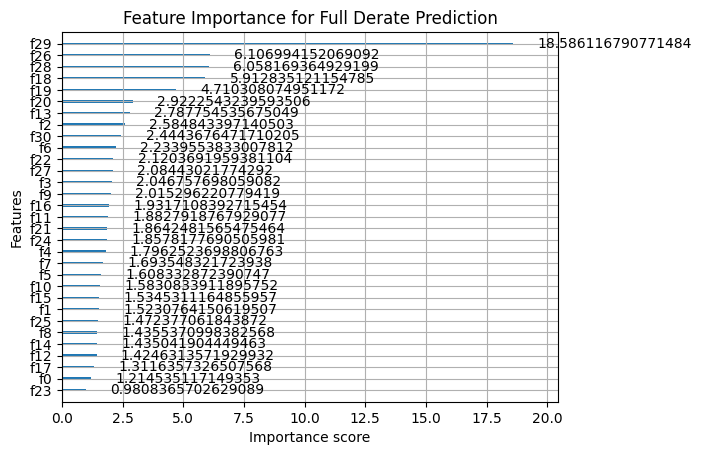

In [29]:
plot_importance_object = plot_importance(xgbc_pipe[1], importance_type='gain')
plt.title('Feature Importance for Full Derate Prediction')
plt.show()

In [30]:
feature_importances = xgbc_pipe[1].feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_30_features = feature_importance_df.head(30)

print(top_30_features)

                     Feature  Importance
29        TurboBoostPressure    0.208448
26                     Speed    0.068491
28                  Throttle    0.067944
18                 FuelLevel    0.066314
19                   FuelLtd    0.052827
20                  FuelRate    0.032774
13                EngineLoad    0.031265
2            ecuSerialNumber    0.028990
30                   spn_fmi    0.027414
6                     active    0.025054
22                 IgnStatus    0.023780
27    SwitchedBatteryVoltage    0.023377
3                   ecuModel    0.022955
9        CruiseControlActive    0.022602
16                 EngineRpm    0.021665
11               DistanceLtd    0.021116
21           FuelTemperature    0.020908
24                LampStatus    0.020836
4                    ecuMake    0.020145
7           AcceleratorPedal    0.018994
5                  ecuSource    0.018038
10     CruiseControlSetSpeed    0.017755
15      EngineOilTemperature    0.017210
1         ecuSof

In [31]:
print("Top 30 features:", top_30_features['Feature'].tolist())

Top 30 features: ['TurboBoostPressure', 'Speed', 'Throttle', 'FuelLevel', 'FuelLtd', 'FuelRate', 'EngineLoad', 'ecuSerialNumber', 'spn_fmi', 'active', 'IgnStatus', 'SwitchedBatteryVoltage', 'ecuModel', 'CruiseControlActive', 'EngineRpm', 'DistanceLtd', 'FuelTemperature', 'LampStatus', 'ecuMake', 'AcceleratorPedal', 'ecuSource', 'CruiseControlSetSpeed', 'EngineOilTemperature', 'ecuSoftwareVersion', 'ParkingBrake', 'BarometricPressure', 'EngineOilPressure', 'EngineCoolantTemperature', 'EngineTimeLtd', 'Unnamed: 0.1']


Now that I'm happy with the results, I want to refit the model on all of the available training data.

In [32]:
test = pd.read_csv('../data/Test_In2019_TimeIntervalLabeled_PerTruck.csv')

In [33]:
FreshTest_In2019 = test
FreshTest_In2019

,Unnamed: 0.1,Unnamed: 0,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,...,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_fmi,is_fullderate,is_fullderate_group,EquipID_Index,time_to_next_SPN5246,time_interval_to_SPN5246_class
0,948793,1062090,1104925,73930906,2019-01-11 12:51:18,High Voltage (Fuel Level),NaN,unknown,unknown,unknown,...,46.52031,NaN,34.4,13.05,96.0_3.0,0,1,301_1,239999976.0,0
1,948794,1062091,1104926,73930907,2019-01-11 12:51:18,High Voltage (Left Fuel Level Sensor),NaN,unknown,unknown,unknown,...,46.52031,NaN,34.4,13.05,829.0_3.0,0,1,301_1,239999976.0,0
2,948799,1062096,1104931,73934247,2019-01-11 13:11:40,High Voltage (Fuel Level),NaN,unknown,unknown,unknown,...,NaN,NaN,NaN,NaN,96.0_3.0,0,1,301_1,239999976.0,0
3,948800,1062097,1104932,73934248,2019-01-11 13:11:40,High Voltage (Left Fuel Level Sensor),NaN,unknown,unknown,unknown,...,NaN,NaN,NaN,NaN,829.0_3.0,0,1,301_1,239999976.0,0
4,948826,1062135,1104970,73942005,2019-01-11 13:13:38,High Voltage (Fuel Level),NaN,unknown,unknown,unknown,...,0.00000,NaN,0.0,1.16,96.0_3.0,0,1,301_1,239999976.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111707,973069,1089938,1137548,80503703,2019-03-16 11:22:32,Incorrect Data J1939 Network #1 Primary Vehicl...,NaN,AAAI000051*AAAM010056*Z091290 *A82J170202A_b...,6232171647,EC80ESP,...,NaN,NaN,NaN,NaN,639.0_2.0,0,0,105437340_0,239999976.0,0
111708,973093,1089962,1137572,80509396,2019-03-16 11:24:04,Special Instructions Engine Starter Solenoid L...,NaN,5569997 *E250.e003*,K1243673,FAOM-xx810S-EC3,...,0.00000,NaN,100.0,0.29,1321.0_14.0,0,0,105437340_0,239999976.0,0
111709,973094,1089963,1137573,80509397,2019-03-16 11:27:41,NaN,NaN,5569997 *E250.e003*,K1243673,FAOM-xx810S-EC3,...,0.00000,NaN,100.0,0.29,520321.0_13.0,0,0,105437340_0,239999976.0,0
111710,974430,1091502,1139112,80907838,2019-03-20 10:57:34,Special Instructions Engine Starter Solenoid L...,NaN,NaN,K1243673,FAOM-xx810S-EC3,...,NaN,NaN,NaN,NaN,1321.0_14.0,0,0,105437340_0,239999976.0,0


In [34]:
FreshTest_In2019[['ecuSource', 'LampStatus', 'time_interval_to_SPN5246_class']] = FreshTest_In2019[['ecuSource', 'LampStatus', 'time_interval_to_SPN5246_class']].astype('str')

In [35]:
X_fresh_test = FreshTest_In2019.drop(columns = [   'Unnamed: 0',
                                                    'RecordID',
                                                    'ESS_Id',
                                                    'actionDescription',
                                                    'spn',
                                                    'fmi',
                                                    'activeTransitionCount',
                                                    'faultValue',
                                                    'MCTNumber',
                                                    'Latitude',
                                                    'Longitude',
                                                    'FaultId',
                                                    'is_fullderate',
                                                    'is_fullderate_group',
                                                    'time_to_next_SPN5246',
                                                    'ServiceDistance',
                                                    'EventTimeStamp',
                                                    'eventDescription',
                                                    'EquipmentID',
                                                    'LocationTimeStamp',
                                                    'EquipID_Index',
                                                    'time_interval_to_SPN5246_class'                                                    
                                                ]
                                     )  
X_fresh_test

,Unnamed: 0.1,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,active,AcceleratorPedal,BarometricPressure,CruiseControlActive,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure,spn_fmi
0,948793,unknown,unknown,unknown,unknown,49,True,34.0,14.5,False,...,71.6,True,84.2,1279.0,False,46.52031,NaN,34.4,13.05,96.0_3.0
1,948794,unknown,unknown,unknown,unknown,49,True,34.0,14.5,False,...,71.6,True,84.2,1279.0,False,46.52031,NaN,34.4,13.05,829.0_3.0
2,948799,unknown,unknown,unknown,unknown,49,False,NaN,NaN,NaN,...,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,96.0_3.0
3,948800,unknown,unknown,unknown,unknown,49,False,NaN,NaN,NaN,...,NaN,NaN,NaN,255.0,NaN,NaN,NaN,NaN,NaN,829.0_3.0
4,948826,unknown,unknown,unknown,unknown,49,True,0.0,14.5,False,...,87.8,True,107.6,1279.0,True,0.00000,NaN,0.0,1.16,96.0_3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111707,973069,AAAI000051*AAAM010056*Z091290 *A82J170202A_b...,6232171647,EC80ESP,BNDWS,11,False,NaN,NaN,NaN,...,NaN,NaN,NaN,50175.0,NaN,NaN,NaN,NaN,NaN,639.0_2.0
111708,973093,5569997 *E250.e003*,K1243673,FAOM-xx810S-EC3,EATON,3,True,0.0,14.5,False,...,NaN,True,68.0,63487.0,True,0.00000,NaN,100.0,0.29,1321.0_14.0
111709,973094,5569997 *E250.e003*,K1243673,FAOM-xx810S-EC3,EATON,3,True,0.0,14.5,False,...,NaN,True,73.4,63487.0,True,0.00000,NaN,100.0,0.29,520321.0_13.0
111710,974430,NaN,K1243673,FAOM-xx810S-EC3,EATON,3,False,NaN,NaN,NaN,...,NaN,NaN,NaN,63487.0,NaN,NaN,NaN,NaN,NaN,1321.0_14.0


In [36]:
X_fresh_test.shape

(111712, 31)

X_FreshTest_Transformed = ct.transform(X_fresh_test)
X_FreshTest_Transformed

In [37]:
y_fresh_pred = xgbc_pipe.predict(X_fresh_test)

In [38]:
y_fresh_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(111712,))

In [39]:
y_fresh_test = FreshTest_In2019['time_interval_to_SPN5246_class']

In [40]:
y_fresh_test_encoded = le_y.transform(y_fresh_test)

In [41]:
accuracy_score(y_fresh_test_encoded, y_fresh_pred)

0.9970817817244343

In [42]:
confusion_matrix(y_fresh_test_encoded, y_fresh_pred)

array([[111386,      0,      8],
       [   155,      0,      0],
       [   163,      0,      0]])

In [43]:
print(classification_report(y_fresh_test_encoded, y_fresh_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    111394
           1       0.00      0.00      0.00       155
           2       0.00      0.00      0.00       163

    accuracy                           1.00    111712
   macro avg       0.33      0.33      0.33    111712
weighted avg       0.99      1.00      1.00    111712



In [44]:
print(f'MSE: {mean_squared_error(y_fresh_test_encoded, y_fresh_pred)}')
print(f'RMSE: {root_mean_squared_error(y_fresh_test_encoded, y_fresh_pred)}')
print(f'MAE: {mean_absolute_error(y_fresh_test_encoded, y_fresh_pred)}')
print(f'MAPE: {mean_absolute_percentage_error(y_fresh_test_encoded, y_fresh_pred)}')
print(f'R2: {r2_score(y_fresh_test_encoded, y_fresh_pred)}')

MSE: 0.0075103838441707245
RMSE: 0.08666247079428745
MAE: 0.004448940131767402
MAPE: 645030023971.7152
R2: -0.04232802002726399


In [45]:
fresh_CV_scores = cross_val_score(xgbc_pipe, X_fresh_test, y_fresh_test_encoded, cv=10, scoring='accuracy')

In [46]:
print('Cross Validation Accuracy Scores:', fresh_CV_scores)

Cross Validation Accuracy Scores: [0.98576799 0.99516649 0.99355474 0.99740399 0.99373377 0.99507654
 0.99731447 0.99650882 0.99552412 0.99758303]


In [47]:
# submission.to_csv('../data/submission_XGBClassifier_TunedHyperparameter_TargetEncoder_LearningRatePt05_MaxTreeDepth5_MinChild1_Estimators199_TestSizePt001_MostFeatures_ExcludingMapCode.csv', index = False)